# Homework 5 - The eternal significance of publications and citations!

## Import libraries

In [ ]:
import pandas as pd
import csv
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import ast
from collections import defaultdict
from tabulate import tabulate
import seaborn as sns
import random
import itertools
import networkx as nx
import heapq

## **[1] Data**

In [ ]:
file_path = "data.json"

### Data pre-processing
The dataset is quite large and may not fit in your memory when you try constructing your graph. So, what is the solution? You should focus your investigation on a subgraph. You can work on the most connected component in the graph. However, you must first construct and analyze the connections to identify the connected components.

#### 1) Identify the top 10,000 papers with the highest number of citations.

To identify the top 10,000 papers with the highest number of citations, firstly we read the data.json file line by line trying to interpret each line as JSON. If it's successful, we extracts the "id" and "n_citation" fields and adds them to the papers list.

In [ ]:
# List to store paper information
papers = []
# Open the file
with open(file_path, "r") as file:
    # Iterate through each line in the file
    for line_number, line in enumerate(file):
        try:
            # Remove any remaining commas, square brackets, or braces
            line = line.strip(',\n')

            try:
                # Load the JSON object from the line
                paper_data = json.loads(line)

                # Extract the relevant information
                paper_id = paper_data["id"]
                # Set number of citations to 0 if it doesn't exist
                paper_citations = paper_data.get("n_citation", 0)

                # Append the information to the 'papers' list
                papers.append({"id": paper_id, "n_citations": paper_citations})

            except json.JSONDecodeError:
                # Print error message for JSON decoding issue and continue to the next line
                print(f"Error in line {line_number}: {line}")
                continue

        except Exception as e:
            # Print generic error message then continue to the next line
            print(f"Generic error in line {line_number}: {line}")
            continue

Error in line 0: [
Error in line 4894082: ]


So now we have a _papers_ list that holds dictionaries where each dictionary contains information about a paper, including its ID and the number of citations it has received. Let's visualize part of it!

In [ ]:
print(papers[:5])

[{'id': 1091, 'n_citations': 1}, {'id': 1388, 'n_citations': 1}, {'id': 1674, 'n_citations': 1}, {'id': 1688, 'n_citations': 6}, {'id': 5411, 'n_citations': 0}]


Now we are going to sort the papers based on the number of citations they have (in descending order), select the top 10,000 papers with the highest citations and creates a separate list containing only their IDs.

In [ ]:
# Sort the list based on the number of citations
papers.sort(key=lambda paper: paper["n_citations"], reverse=True)
# Extract the top 10000
top_10000_papers = papers[:10000]
# Insert id values in a list
papers_id=[paper["id"] for paper in top_10000_papers]
print(f"We extracted {len(papers_id)} ids.")
has_duplicates = len(papers_id) != len(set(papers_id))
if has_duplicates:
    print("The list papers_id contains duplicates.")
else:
    print("The list papers_id does not contain duplicates.")
print(f"So now we have a list of ids, let's visualize a small part of it: {papers_id[:5]}.")

We extracted 10000 ids.
The list papers_id does not contain duplicates.
So now we have a list of ids, let's visualize a small part of it: [2041404167, 1639032689, 2912565176, 2151103935, 2911964244].


At this point, we are going to re-read each line from the file and appending it to a new DataFrame only if its ID is among the top 10,000 papers' IDs. At the end we should have a dataframe with 10,000 rows, which will be the dataframe we'll be working on.

In [ ]:
# Initialize an empty DataFrame for the top 10,000 papers
top_10000_papers_df = pd.DataFrame()

# Open the JSON file
with open(file_path, "r") as file:
    for line in file:
        try:
            # Remove any remaining commas, square brackets, or braces
            line = line.strip(',\n')

            # Load the line as a JSON object
            paper_data = json.loads(line)

            # Check if the paper's ID is in the list of IDs of the top 10,000 papers
            if "id" in paper_data and paper_data["id"] in papers_id:
                # Load the JSON into a temporary DataFrame and append to the main DataFrame
                tmp_df = pd.read_json(line, lines=True)
                top_10000_papers_df = pd.concat([top_10000_papers_df, tmp_df], ignore_index=True)

        except json.JSONDecodeError as e:
            print(f"Error in line: {line}. Error: {e}")
            continue
        except Exception as e:
            print(f"Error in line: {line}. Error: {e}")
            continue

Error in line: [. Error: Expecting value: line 1 column 2 (char 1)
Error in line: ]. Error: Expecting value: line 1 column 1 (char 0)


Let's verify that the new DataFrame has 10,000 rows!

In [ ]:
num_rows = len(top_10000_papers_df)
print("The total number of rows in the DataFrame is:", num_rows)

The total number of rows in the DataFrame is: 10000


We'll now save this DataFrame into a JSON file to avoid rerunning the previous code (which takes some time)

In [ ]:
# Save results in a JSON file
top_10000_papers_df.to_json("top_10000_papers_json.json", orient="records")

Let's read this JSON file , load it into a Pandas DataFrame and analize it !

In [ ]:
# Read the JSON file into a DataFrame
top_10000_papers_df = pd.read_json("top_10000_papers_json.json")

# Display the number of rows and columns
num_rows, num_columns = top_10000_papers_df.shape
print(f"Number of rows in the DataFrame: {num_rows}")
print(f"Number of columns in the DataFrame: {num_columns}")

# Display columns in the DataFrame
print("Column Name and Data Type:")
print(top_10000_papers_df.dtypes)

# Count the number of null values per column
null_counts = top_10000_papers_df.isnull().sum()
print("\nNull value counts per column:")
print(null_counts)

# Count the total number of null values in the DataFrame
total_null_values = top_10000_papers_df.isnull().sum().sum()
print(f"\nTotal number of null values in the DataFrame: {total_null_values}")

Number of rows in the DataFrame: 10000
Number of columns in the DataFrame: 17
Column Name and Data Type:
id                   int64
authors             object
title               object
year                 int64
n_citation           int64
page_start          object
page_end            object
doc_type            object
publisher           object
volume              object
issue               object
doi                 object
fos                 object
venue               object
references          object
indexed_abstract    object
alias_ids           object
dtype: object

Null value counts per column:
id                     0
authors                0
title                  0
year                   0
n_citation             0
page_start             0
page_end               0
doc_type               0
publisher              0
volume                 0
issue                  0
doi                    0
fos                    1
venue                399
references          1204
indexed_abstract

#### 2) Based on the available data, you will create two graphs:

##### - Citation graph:
This graph should represent the paper's citation relationships. We want this graph to be **unweighted** and **directed**. The citation should represent the citation given from one paper to another. For example, if paper A has cited paper B, we should expect an edge from node A to B.

- **Nodes:** You can consider each of the papers as your nodes.
- **Edges:** Only consider the citation relationship between these 10,000 papers and ignore the rest.


In this case, we'll only need the 'id' and 'references' columns from the new DataFrame, so let's select just those columns and work with them for simplicity.

In [ ]:
# Select only 'id' e 'references' columns
selected_columns = top_10000_papers_df[['id', 'references']]
print(selected_columns.head())

        id                                         references
0   852874                                               None
1  1699105  [17553438, 29630963, 149636774, 1488905225, 15...
2  2169610                                               None
3  4214443  [1965321492, 2082372845, 2103944702, 210478924...
4  4508078                                               None


We create our graph considering that we have to consider each of the papers as our nodes so it means that we will have 10000 different nodes and that we have to to consider only the citation relationships between these 10,000 papers and ignore the rest.

In [ ]:
# Create an empty directed graph for citations
citation_graph = nx.DiGraph()

# Get all unique paper IDs from the dataset
unique_ids = selected_columns["id"].unique()

# Add all paper IDs as nodes to the graph
citation_graph.add_nodes_from(unique_ids)

# Add edges only for references present in the dataset
for _, row in selected_columns.iterrows():
    paper_id = row["id"]
    references = row["references"]

    # Check if references is not None before iterating
    if references is not None:
        for ref_id in references:
            if ref_id in unique_ids:
                citation_graph.add_edge(paper_id, ref_id)

Let's verify that we have 10000 nodes

In [ ]:
# Print the number of nodes in the graph
print("The number of nodes of the Citation Graph is:", len(citation_graph.nodes))
# Print the number of edges in the graph
print("The number of edges of the Citation Graph is:", len(citation_graph.edges))

The number of nodes of the Citation Graph is: 10000
The number of edges of the Citation Graph is: 52253


The graph is very big so we decided to plot the **strongly connected components**. The strongly connected components in a directed graph are subsets of nodes where every node within the subset can be reached from every other node using directed edges within that subset.

In [ ]:
# Find the strongly connected components
scc = list(nx.strongly_connected_components(citation_graph))
# Find the largest component
largest_scc = max(scc, key=len)
# Extract the subgraph related to the largest component
citation_subgraph = citation_graph.subgraph(largest_scc)

# Print the number of nodes
print("The number of nodes of the Citation SubGraph is:", len(citation_subgraph.nodes))
# Print the number of edges
print("The number of edges of the Citation SubGraph is:", len(citation_subgraph.edges))


The number of nodes of the Citation SubGraph is: 56
The number of edges of the Citation SubGraph is: 238


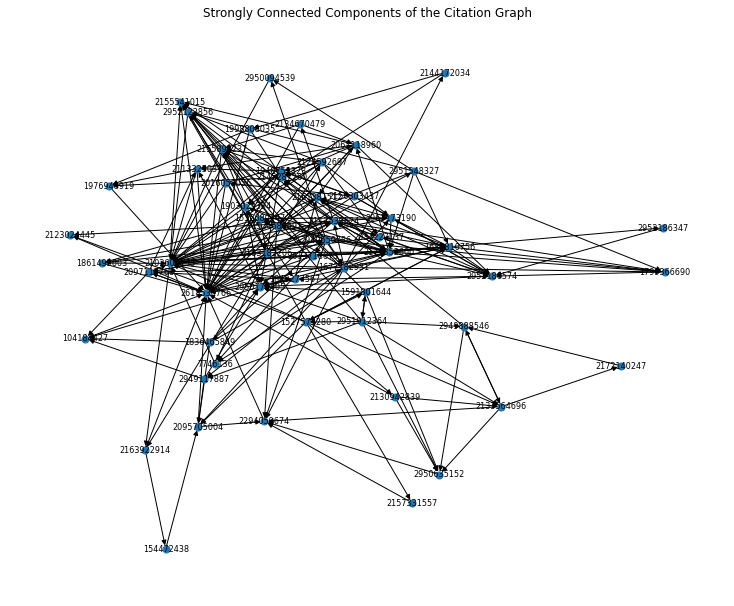

In [ ]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(citation_subgraph)
nx.draw(citation_subgraph, pos, with_labels=True, node_size=50, font_size=8)
plt.title('Strongly Connected Components of the Citation Graph')
plt.show()

##### - Collaboration graph:
This graph should represent the collaborations of the paper's authors. This graph should be **weighted** and **undirected**. Consider an appropriate weighting scheme for your edges to make your graph weighted.

- **Nodes:** The authors of these papers would be your nodes

- **Edges:** Only consider the collaborations between the authors of these 10,000 papers and ignore the rest.


In [ ]:
# Read the top 10,000 papers from the JSON file
top_papers = pd.read_json('top_10000_papers_json.json')

# Create an empty undirected graph for the collaborations
collaboration_graph = nx.Graph()

# Initialize a dictionary to store the count of collaborations between each pair of authors
collaboration_count = defaultdict(lambda: {'count': 0, 'titles': []})

# Iterate over the rows in the dataframe
for _, row in top_papers.iterrows():
    # Get the author dictionaries for the current paper
    author_dicts = row["authors"]

    # Extract titles
    paper_title = row["title"]

    # Iterate over each author dictionary
    for author_dict in author_dicts:
        # Extract the author ID
        author_id = author_dict['id']

        # Iterate over the rest of the author dictionaries
        for other_author_dict in author_dicts:
            # Extract the other author ID
            other_author_id = other_author_dict['id']

            # If the author is not the same as the other author
            if author_id != other_author_id:
                # Increment the count of collaborations between these two authors
                collaboration_count[(author_id, other_author_id)]['count'] += 1
                # Add the title to the titles list for this collaboration
                collaboration_count[(author_id, other_author_id)]['titles'].append(paper_title)

# Add nodes to the graph for each author
for key in collaboration_count.keys():
    # Each key is a tuple of two author IDs
    for author_id in key:
        # Add the author as a node in the graph
        collaboration_graph.add_node(author_id)

# Add edges to the graph for each collaboration, with the weight equal to the count of collaborations
for (author_id1, author_id2), data in collaboration_count.items():
    # Extract collaboration count and titles
    count = data['count']
    titles = data['titles']
    edge_title = titles[-1] if titles else None

    # Add an edge between the authors in the graph, with the weight equal to the count of collaborations
    collaboration_graph.add_edge(author_id1, author_id2, weight=count, titles=edge_title)


Let's see how many nodes and edges has our Collaboration Graph:

In [ ]:
# Print the number of nodes
print("The number of nodes of the Collaboration SubGraph is:", len(collaboration_graph.nodes))
# Print the number of edges
print("The number of edges of the Collaboration SubGraph is:", len(collaboration_graph.edges))

The number of nodes of the Collaboration SubGraph is: 20202
The number of edges of the Collaboration SubGraph is: 136476


Given the high number of nodes in the graph, we won't represent it graphically

## **[2] Controlling system**

### 2.1) Backend Implementation

#### *Functionality 1 - Graph's features**

This function should *examine a graph and report on some of its features*. The input and report that this function should produce are shown below.

Input:

- The graph \\
- The name of the graph \\

Output:

- The number of the nodes in the graph
- The number of the edges in the graph
- The graph density
- The graph degree distribution
- The average degree of the graph
- The graph hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)
- Whether the graph is dense or sparse

#### *Functionality 1 Description*

The `functionality1` code analyzes a given graph's characteristics and provides key metrics and statistics. The following aspects are assessed:

1. **Number of Nodes and Edges:**
   - *Number of Nodes*: The total number of nodes in the graph.
   - *Number of Edges*: The total number of edges in the graph.

2. **Graph Density:**
   - *Graph Density*: The density of the graph, calculated using NetworkX's density function. It provides an indication of how connected the graph is.

3. **Degree Distribution:**
   - *Degree Distribution*: A sorted list representing the degree of each node in the graph in descending order.
   
4. **Average Degree:**
   - *Average Degree*: The average degree of all nodes in the graph.

5. **95th Percentile of Degree Distribution:**
   - *95th Percentile*: The value below which 95% of the node degrees fall.

6. **Graph Hubs:**
   - *Graph Hubs*: Nodes with a degree higher than the 95th percentile.

7. **Graph Density Status:**
   - *Graph Density Status*: Indicates whether the graph is considered dense or sparse based on a threshold of 0.5. If the density is greater than 0.5, it's labeled as dense; otherwise, it's considered sparse.

In [ ]:
def functionality1(graph, graph_name):
    # Number of nodes
    num_nodes = graph.number_of_nodes()

    # Number of edges
    num_edges = graph.number_of_edges()

    # Graph density
    density = nx.density(graph)

    # Degree distribution
    degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)

    # Average degree
    avg_degree = np.mean(degree_sequence)

    # 95th percentile of the degree distribution
    percentile_95 = np.percentile(degree_sequence, 95)

    # Graph hubs
    hubs = [node for node, degree in graph.degree() if degree > percentile_95]

    # Whether the graph is dense or sparse
    if density > 0.5:
        density_status = "dense"
    else:
        density_status = "sparse"

    # Output
    output = {
        "Graph Name": graph_name,
        "Number of Nodes": num_nodes,
        "Number of Edges": num_edges,
        "Graph Density": density,
        "Degree Distribution": degree_sequence,
        "Average Degree": avg_degree,
        "Graph Hubs": hubs,
        "Graph Density Status": density_status
    }

    return output

--------------------------------------------------------------------------------

#### *Functionality 2 - Nodes' contribution*

Using this functionality, you will identify the papers/authors who have significantly contributed to this field of study. For this analysis, focusing solely on the number of citations for the paper or the number of collaborations of the authors can be misleading. You will examine this using various centrality measurements.

Input:

- The graph
- A node of the graph (paper/author)
- The name of the graph

Output:

- The centrality of the node, calculated based on the following centrality measurements:
- [Betweeness](https://www.tandfonline.com/doi/abs/10.1080/0022250X.2001.9990249+)

- [PageRank](https://courses.cs.washington.edu/courses/cse373/17au/project3/project3-3.html)
- [ClosenessCentrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality)
- [DegreeCentrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html)

#### *Functionality 2 Description*

The `functionality2` code calculates centrality measurements for a specific node in a given graph.

1. **Betweenness Centrality:**
   - *Betweenness Centrality*: A measure of how often a node acts as a bridge along the shortest path between two other nodes.

2. **PageRank Centrality:**
   - *PageRank Centrality*: An algorithm that assigns a numerical weight to each node based on its connections in the graph.

3. **Closeness Centrality:**
   - *Closeness Centrality*: Measures how close a node is to all other nodes in the graph, emphasizing short paths.

4. **Degree Centrality:**
   - *Degree Centrality*: The fraction of nodes a node is connected to, providing a basic measure of its connectivity.

In [ ]:
def functionality2(graph, node, graph_name):
    # Calculate centrality measurements
    betweenness_centrality = nx.betweenness_centrality(graph)[node]
    pagerank_centrality = nx.pagerank(graph)[node]
    closeness_centrality = nx.closeness_centrality(graph)[node]
    degree_centrality = nx.degree_centrality(graph)[node]

    # Output
    output = {
        "Graph Name": graph_name,
        "Node": node,
        "Betweenness Centrality": betweenness_centrality,
        "PageRank Centrality": pagerank_centrality,
        "Closeness Centrality": closeness_centrality,
        "Degree Centrality": degree_centrality
    }

    return output

--------------------------------------------------------------------------------

#### *Functionality 3 - Shortest ordered walk*



Input:

- The graph data
- A sequence of authors_a = [a_2, ..., a_{n-1}]
- Initial node a_1 and an end node a_n
- N : denoting the top N
 authors whose data should be considered

Output:

The shortest walk of collaborations you need to read to get from author a_1 to author a_n and the papers you need to cross to realize this walk.
Considerations: For this functionality, you must implement an algorithm that returns the shortest walk that goes from node a_j to a_n, which visits in order the nodes in a. The choice of a_j and a_n can be made randomly (or if it improves the performance of the algorithm, you can also define it in any other way)

***Important Notes:***

- This algorithm should be run only on the collaboration graph.
- The algorithm needs to handle the case that the graph is not connected. Thus, only some nodes in a are reachable from a_1. In such a scenario, it is enough to let the program give in the output the string "There is no such path."
- Since we are dealing with walks, you can pass on the same node a_i more than once, but you must preserve order. It means you can go back to any author node any time you want, assuming that the order in which you visit the required nodes is still the same.
- Once you completed your implementation, ask chatGPT for a different one leveraging another approach in solving the shortest path and prove whether this implementation is correct.

#### *Functionality 3 Description*

##### `remove_consecutive_duplicates` Function:

- **Description:** Removes consecutive duplicates from a list.
- **Parameters:**
  - `lst`: The input list from which consecutive duplicates are to be removed.
- **Return:**
  - Returns a new list with consecutive duplicates removed.

##### `get_papers_between_nodes` Function:

- **Description:** Retrieves the titles of papers between two nodes in a graph.
- **Parameters:**
  - `graph`: The graph containing nodes and edges.
  - `node1`, `node2`: Nodes between which the titles of papers are sought.
- **Return:**
  - Returns a list of titles of papers between the specified nodes.

##### `get_path_between_nodes` Function:

- **Description:** Retrieves the shortest path between two nodes in a graph.
- **Parameters:**
  - `graph`: The graph containing nodes and edges.
  - `node1`, `node2`: Nodes between which the shortest path is sought.
- **Return:**
  - Returns a list representing the shortest path between the specified nodes.

##### `shortest_ordered_walk` Function:

- **Description:** Finds the shortest ordered walk between initial and end nodes, crossing N random authors.
- **Parameters:**
  - `graph_data`: The graph data (it is checked if it's the collaboration graph).
  - `initial_node`, `end_node`: Nodes representing the start and end of the walk.
  - `N`: Number of random authors to be crossed.
- **Return:**
  - Returns a tuple containing:
    - `subgraph_auth`: The subgraph with nodes representing the randodom authors and initial/end nodes.
    - `shortest_walk_out`: The shortest ordered walk between nodes.
    - `cross_papers_out`: The titles of papers crossed during the walk.


In [ ]:
def remove_consecutive_duplicates(lst):
    """
    Removes consecutive duplicates from a list.
    """
    if len(lst) < 2:
        return lst

    result = [lst[0]]

    for i in range(1, len(lst)):
        if lst[i] != lst[i - 1]:
            result.append(lst[i])

    return result

def get_papers_between_nodes(graph, node1, node2):
    """
    Returns the titles of papers between two nodes in the graph.
    """
    papers = []
    try:
        papers = graph[node1][node2]['titles']
    except KeyError:
        print(f"No titles found between nodes {node1} and {node2}")
    return papers

def get_path_between_nodes(graph, node1, node2):
    """
    Returns the shortest path between two nodes in the graph.
    """
    try:
        shortest_path = nx.shortest_path(graph, node1, node2)
    except nx.NetworkXNoPath:
        print(f"No path found between nodes {node1} and {node2}")
        shortest_path = []
    return shortest_path

def shortest_ordered_walk(graph_data, initial_node, end_node, N):
    """
    Finds the shortest ordered walk between initial and end nodes, crossing N random authors.
    """
    if graph_data is not collaboration_graph:
        return 'No walk calculated, you should insert the Collaboration graph'

    degrees = dict(graph_data.degree())
    top_N = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:N]
    subgraph_auth = graph_data.subgraph([author for author, _ in top_N])
    nodes = list(subgraph_auth.nodes())
    initial_node = nodes[0]
    end_node = nodes[1]

    excluded_authors = [author for author in nodes if author not in [initial_node, end_node]]
    num_random_authors = random.randint(1, min(N - 2, len(excluded_authors)))
    random_authors = random.sample(excluded_authors, num_random_authors)

    print("Authors Nodes: ", nodes)
    print("Initial Node: ", initial_node)
    print("End Node: ", end_node)
    print("Authors to cross:", random_authors)

    if not nx.is_connected(subgraph_auth):
        return 'No walk calculated, the subgraph is not connected'

    permutations = list(itertools.permutations(random_authors))

    for i in range(len(permutations)):
        permutations[i] = permutations[i] + (end_node,)

    shortest_walk = []
    cross_papers = []
    min_length = float('inf')

    for permutation in permutations:
        temp_walk = [initial_node] + list(permutation)
        path = []
        papers = []

        for i in range(len(temp_walk) - 1):
            current_node = temp_walk[i]
            next_node = temp_walk[i + 1]

            papers_between_nodes = get_papers_between_nodes(subgraph_auth, current_node, next_node)
            papers += papers_between_nodes

            path_between_nodes = get_path_between_nodes(subgraph_auth, current_node, next_node)
            path += path_between_nodes

        if len(path) < min_length:
            min_length = len(path)
            shortest_walk = path
            cross_papers = papers

    cross_papers_out = remove_consecutive_duplicates(cross_papers)
    shortest_walk_out = remove_consecutive_duplicates(shortest_walk)

    return subgraph_auth, shortest_walk_out, cross_papers_out

> Ask ChatGpt for an implementation leveraging another approach in solving the shortest path and prove whether this implementation is correct.

We asked [Phind](https://www.phind.com/) to implement the algorithm and here's what eh answered: \\

Here is the Python code implementing Dijkstra's algorithm:

In [ ]:
def dijkstra(graph, initial_node, end_node):
   """
   Implements Dijkstra's algorithm to find the shortest path between two nodes in a graph.
   """
   # Initialize the dictionary to store distances to all nodes
   distances = {node: float('infinity') for node in graph}
   distances[initial_node] = 0

   # Use a priority queue to select the node with the smallest tentative distance
   queue = [(0, initial_node)]

   while queue:
       current_distance, current_node = heapq.heappop(queue)

       if current_distance > distances[current_node]:
           continue

       for neighbor, weight in graph[current_node].items():
           old_distance = distances[neighbor]
           new_distance = current_distance + weight

           if new_distance < old_distance:
               distances[neighbor] = new_distance
               heapq.heappush(queue, (new_distance, neighbor))

   return distances[end_node]

In this implementation, we first initialize a dictionary to store the tentative distances to all nodes. We then use a priority queue to select the node with the smallest tentative distance at each step. For each neighbor of the current node, we calculate the tentative distance to the neighbor through the current node. If this distance is less than the previously known distance to the neighbor, we update the distance and add the neighbor to the priority queue.

This implementation assumes that the graph is represented as a dictionary where the keys are nodes and the values are dictionaries representing the neighbors of each node and the weights of the edges to those neighbors

The AI implementation seems to be correct because of the properties of the algorithm:

1. Dijkstra's algorithm always provides an optimal solution, meaning it finds the shortest possible path from the source node to every other node in the graph.When we iterate over all the paths from the initial node to the end node, we keep track of the shortest path found so far and update it whenever we find a shorter path.

2. Dijkstra's algorithm is correct if the graph doesn't contain any negative weight cycles. The implementation seems to handle this situation correctly. If there's no path between two nodes, it prints a message indicating that no path was found.

3. Dijkstra's algorithm is guaranteed to terminate if all edge weights are nonnegative. Your implementation seems to handle this situation correctly as well. If there's no connection between the initial and end nodes, the implementation returns an empty list.

So, based on these properties, the implementation of the algorithm appears to be correct.



--------------------------------------------------------------------------------

#### *Functionality 4 - Disconnecting Graphs*

Input:

- The graph data
- authorA: a paper to which will relate sub-graph G_a
- authorB: a paper to which will relate sub-graph G_b
- N: denoting the top N
 authors that their data should be considered
Output:

The minimum number of edges (by considering their weights) required to disconnect the original graph in two disconnected subgraphs: G_a and G_b.

--------------------------------------------------------------------------------

#### *Functionality 5 - Disconnecting Graphs*

Input:

- The graph data
- N : denoting the top N
 papers that their data should be considered
- Paper_1: denoting the name of one of the papers
- Paper_2: denoting the name of one of the papers

Output:

- The minimum number of edges that should be removed to form communities
- A list of communities, each containing a list of papers that belong to them.
- Whether the Paper_1 and Paper_2 belongs to the same community.

**Important Notes:***
To comprehend this functionality better, we suggest you take a good look at [this article](https://www.analyticsvidhya.com/blog/2020/04/community-detection-graphs-networks/)

#### *Functionality 5 Description*

**`edge_to_remove` function:**
- Calculates the edge betweenness centrality for each edge in the graph.
- Sorts edges based on their betweenness centrality in descending order.
- Extracts the top N edges to be removed based on centrality.

**`functionality5` function:**
- Extracts the top N papers based on degree.
- Creates a subgraph using only the top N papers.
- Converts the subgraph to an undirected graph.
- Identifies the top edges to be removed using the `edge_to_remove` function.
- Removes edges not present in the top edges from the subgraph.
- Finds the number of connected components in the subgraph after removing edges.
- Calculates the minimum number of edges to be removed.
- Checks if Paper_1 and Paper_2 belong to the same community.
- Outputs the results containing the minimum number of edges to be removed, communities, and whether Paper_1 and Paper_2 are in the same community.


In [ ]:
def edge_to_remove(graph, n_top_papers):
    # Compute edge betweenness centrality for each edge in the graph
    G_dict = nx.edge_betweenness_centrality(graph)

    # Sort edges based on their betweenness centrality in descending order
    top_edges = sorted(G_dict.items(), key=lambda item: item[1], reverse=True)[:n_top_papers]

    # Extract the edges to be removed from the top edges
    edges_to_remove = [edge[0] for edge in top_edges]

    return edges_to_remove

def functionality5(graph, n_top_papers, paper_1, paper_2):
    # Extract top N papers based on degree
    top_papers = [node for node, _ in sorted(graph.degree, key=lambda x: x[1], reverse=True)[:n_top_papers]]

    # Create a subgraph using only the top N papers
    subgraph = graph.subgraph(top_papers).copy()

    # Convert the subgraph to an undirected graph
    subgraph = subgraph.to_undirected()

    # Identify the top edges to be removed using edge_to_remove function
    edges_to_remove = edge_to_remove(subgraph, n_top_papers)

    # Remove edges not present in the top edges from the subgraph
    subgraph.remove_edges_from(e for e in subgraph.edges() if e not in edges_to_remove)

    # Find the number of connected components after removing edges
    sg = list(nx.connected_components(subgraph))

    # Compute the minimum number of edges to be removed
    min_edges_to_remove = len(subgraph.edges()) - len(edges_to_remove)

    # Check if Paper_1 and Paper_2 belong to the same community
    papers_in_same_community = any(paper_1 in community and paper_2 in community for community in sg)

    # Output the results
    return min_edges_to_remove, sg, papers_in_same_community

### 2.2. Frontend Implementation

#### Visualization 1 - Visualize graph features

**1. A table containing the following general information about the graph:**

- **Number of nodes in the graph**
- **Number of edges in the graph**
- **Density of the graph**
- **Average degree of the graph**
- **Whether the network is sparse or dense**


Citation Graph:

In [ ]:
# Get data for the table using the functionality1 function
output_data = functionality1(citation_graph, graph_name='citation_graph')

# Organize data for the table
table_data = [
    ["Name of Graph", output_data["Graph Name"]],
    ["Number of nodes in the Graph", output_data["Number of Nodes"]],
    ["Number of edges in the Graph", output_data["Number of Edges"]],
    ["Density of the Graph", output_data["Graph Density"]],
    ["Average degree of the Graph", output_data["Average Degree"]],
    ["The Graph is", output_data["Graph Density Status"]]
]

# Print the table using tabulate
print(tabulate(table_data, headers=["Attribute", "Value"], tablefmt="grid"))


+------------------------------+-----------------------+
| Attribute                    | Value                 |
+==============================+=======================+
| Name of Graph                | citation_graph        |
+------------------------------+-----------------------+
| Number of nodes in the Graph | 10000                 |
+------------------------------+-----------------------+
| Number of edges in the Graph | 52253                 |
+------------------------------+-----------------------+
| Density of the Graph         | 0.0005225822582258226 |
+------------------------------+-----------------------+
| Average degree of the Graph  | 10.4506               |
+------------------------------+-----------------------+
| The Graph is                 | sparse                |
+------------------------------+-----------------------+


Collaboration Graph:

In [ ]:
# Get data for the table using the functionality1 function
output_data = functionality1(collaboration_graph, graph_name='collaboration_graph')

# Organize data for the table
table_data = [
    ["Name of Graph", output_data["Graph Name"]],
    ["Number of nodes in the Graph", output_data["Number of Nodes"]],
    ["Number of edges in the Graph", output_data["Number of Edges"]],
    ["Density of the Graph", output_data["Graph Density"]],
    ["Average degree of the Graph", output_data["Average Degree"]],
    ["The Graph is", output_data["Graph Density Status"]]
]

# Print the table using tabulate
print(tabulate(table_data, headers=["Attribute", "Value"], tablefmt="grid"))

+------------------------------+----------------------+
| Attribute                    | Value                |
+==============================+======================+
| Name of Graph                | collaboration_graph  |
+------------------------------+----------------------+
| Number of nodes in the Graph | 20202                |
+------------------------------+----------------------+
| Number of edges in the Graph | 136476               |
+------------------------------+----------------------+
| Density of the Graph         | 0.000668835082972997 |
+------------------------------+----------------------+
| Average degree of the Graph  | 13.51113751113751    |
+------------------------------+----------------------+
| The Graph is                 | sparse               |
+------------------------------+----------------------+


**2. A table that lists the graph's hubs**

Citation Graph:

In [ ]:
# Execute functionality1 function to get graph and hub data
output_data = functionality1(citation_graph, graph_name='citation_graph')

# Extract relevant data from the output
graph_name = output_data["Graph Name"]
hubs = output_data["Graph Hubs"]

# Consider only the first 10 hubs
first_10_hubs = hubs[:10]

# Convert node numbers into a list of lists for tabulate, directly converting nodes to strings
hub_table = [[index, str(node)] for index, node in enumerate(first_10_hubs, start=1)]

# Create a table using tabulate
table = tabulate(hub_table, headers=["Index", "Node"], tablefmt="grid")

# Print the table
print(table)

+---------+------------+
|   Index |       Node |
+=========+============+
|       1 | 1480415088 |
+---------+------------+
|       2 | 1481420047 |
+---------+------------+
|       3 | 1499049447 |
+---------+------------+
|       4 | 1480376833 |
+---------+------------+
|       5 | 1502916507 |
+---------+------------+
|       6 | 1506285740 |
+---------+------------+
|       7 | 1515402129 |
+---------+------------+
|       8 | 1520914943 |
+---------+------------+
|       9 | 1535271175 |
+---------+------------+
|      10 | 1536680647 |
+---------+------------+


Collaboration Graph:

In [ ]:
# Execute functionality1 function to get graph and hub data
output_data = functionality1(collaboration_graph, graph_name='colaboration_graph')

# Extract relevant data from the output
graph_name = output_data["Graph Name"]
hubs = output_data["Graph Hubs"]

# Consider only the first 10 hubs
first_10_hubs = hubs[:10]

# Convert node numbers into a list of lists for tabulate, directly converting nodes to strings
hub_table = [[index, str(node)] for index, node in enumerate(first_10_hubs, start=1)]

# Create a table using tabulate
table = tabulate(hub_table, headers=["Index", "Node"], tablefmt="grid")

# Print the table
print(table)

+---------+------------+
|   Index |       Node |
+=========+============+
|       1 |  295353625 |
+---------+------------+
|       2 |  161269817 |
+---------+------------+
|       3 | 2104401652 |
+---------+------------+
|       4 | 2075956027 |
+---------+------------+
|       5 |  215131072 |
+---------+------------+
|       6 | 1111049960 |
+---------+------------+
|       7 | 2004792601 |
+---------+------------+
|       8 | 2485834696 |
+---------+------------+
|       9 | 2462121670 |
+---------+------------+
|      10 | 2328522601 |
+---------+------------+


**3. A plot depicting the distribution of the citations received by papers (Citation graph)**

**Note** : For the points 3 and 4 we choosed to analyze the strongly connected component (previously defined). Focusing on the strongly connected component helps analyze citations among closely linked papers, offering a clearer picture of meaningful interactions and reducing noise from less relevant citations

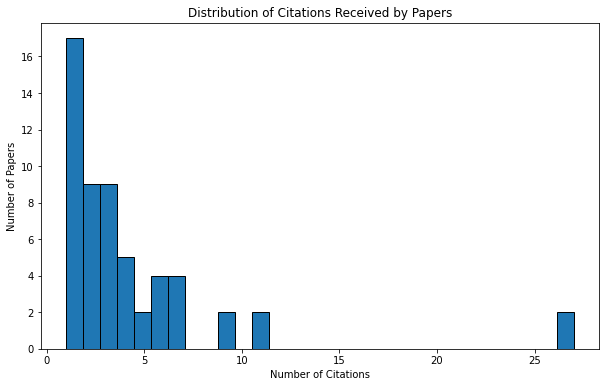

In [ ]:
# Calculate the number of citations received by each paper in the citation graph
citation_counts = [d for n, d in citation_subgraph.in_degree()]

# Create the plot
plt.figure(figsize=(10, 6))
plt.hist(citation_counts, bins=30, edgecolor='black')  # Crea l'istogramma usando Matplotlib
plt.title('Distribution of Citations Received by Papers')
plt.xlabel('Number of Citations')
plt.ylabel('Number of Papers')
plt.show()

**4. A plot depicting the distribution of the given citations by papers (Citation graph)**

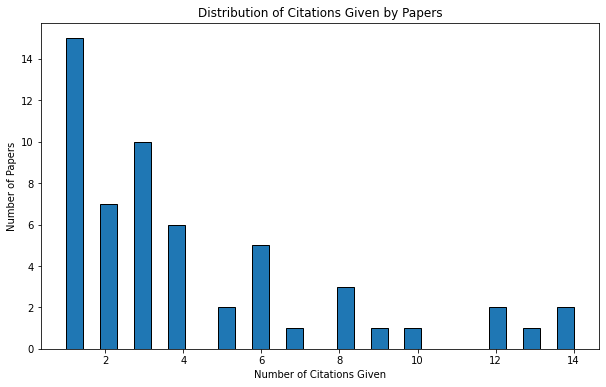

In [ ]:
# Calculate the number of citations given by each paper in the citation graph
citations_given = [d for n, d in citation_subgraph.out_degree()]

# Create the histogram depicting the distribution of citations given
plt.figure(figsize=(10, 6))
plt.hist(citations_given, bins=30, edgecolor='black')
plt.title('Distribution of Citations Given by Papers')
plt.xlabel('Number of Citations Given')
plt.ylabel('Number of Papers')
plt.show()

**5. A plot depicting the number of collaborations of the author (Collaboration graph)**

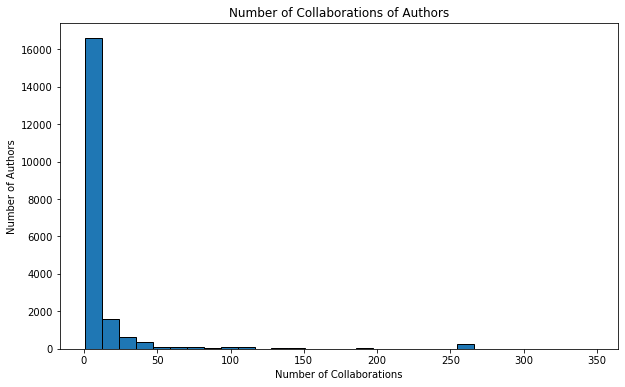

In [ ]:
# Calculate the number of collaborations for each author
collaborations = collaboration_graph.degree()

# Extract the degrees (number of collaborations) for each author
degrees = [degree for author, degree in collaborations]

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=30, edgecolor='black')
plt.title('Number of Collaborations of Authors')
plt.xlabel('Number of Collaborations')
plt.ylabel('Number of Authors')
plt.show()


#### Visualization 2 - Visualize the node's contribution

**1. A table containing the node's centrality value based on the four centrality measurements**


Citation Graph:

In [ ]:
# Extract a random node from the graph
random_node = random.choice(list(citation_graph.nodes()))

# Call functionality2 to get centrality measurements for that specific node
result = functionality2(citation_graph, random_node, graph_name='citation_graph')

# Extract centrality values and convert to strings
node = str(result['Node'])
betweenness = str(result['Betweenness Centrality'])
pagerank = str(result['PageRank Centrality'])
closeness = str(result['Closeness Centrality'])
degree_centrality = str(result['Degree Centrality'])

# Create a table of centrality values
centrality_table = [
    ['Node', 'Betweenness Centrality', 'PageRank Centrality', 'Closeness Centrality', 'Degree Centrality'],
    [node, betweenness, pagerank, closeness, degree_centrality]
]

# Display the table
print(tabulate(centrality_table, headers='firstrow'))

      Node    Betweenness Centrality    PageRank Centrality    Closeness Centrality    Degree Centrality
----------  ------------------------  ---------------------  ----------------------  -------------------
2153950497                         0            3.67648e-05                       0           0.00070007


Collaboration Graph:

In [ ]:
# Extract a random node from the graph
random_node = random.choice(list(collaboration_graph.nodes()))

# Call functionality2 to get centrality measurements for that specific node
result = functionality2(collaboration_graph, random_node, graph_name='collaboration_graph')

# Extract centrality values and convert to strings
node = str(result['Node'])
betweenness = str(result['Betweenness Centrality'])
pagerank = str(result['PageRank Centrality'])
closeness = str(result['Closeness Centrality'])
degree_centrality = str(result['Degree Centrality'])

# Create a table of centrality values
centrality_table = [
    ['Node', 'Betweenness Centrality', 'PageRank Centrality', 'Closeness Centrality', 'Degree Centrality'],
    [node, betweenness, pagerank, closeness, degree_centrality]
]

# Display the table
print(tabulate(centrality_table, headers='firstrow'))

      Node    Betweenness Centrality    PageRank Centrality    Closeness Centrality    Degree Centrality
----------  ------------------------  ---------------------  ----------------------  -------------------
2153823796                         0            5.68812e-05             0.000419315          0.000346517


#### Visualization 3 - Visualize the shortest-ordered route

The `shortest_ordered_walk` function firstlt extract a subset of the graph consisting of the top-N nodes with the highest degrees and then designates the first and second nodes in that subset as the initial and end. Then the authors_list is builded extracting random authors (and also a random number of authors from 1 to N) from the list of nodes of the subgraph, excluding the initial and end nodes. Then the function returns the functionality requested output.

Authors Nodes:  [1973035492, 1976452423, 332422508, 173839695, 2146468246]
Initial Node:  1973035492
End Node:  1976452423
Authors to cross: [173839695, 332422508]
No titles found between nodes 332422508 and 1976452423
No titles found between nodes 173839695 and 1976452423


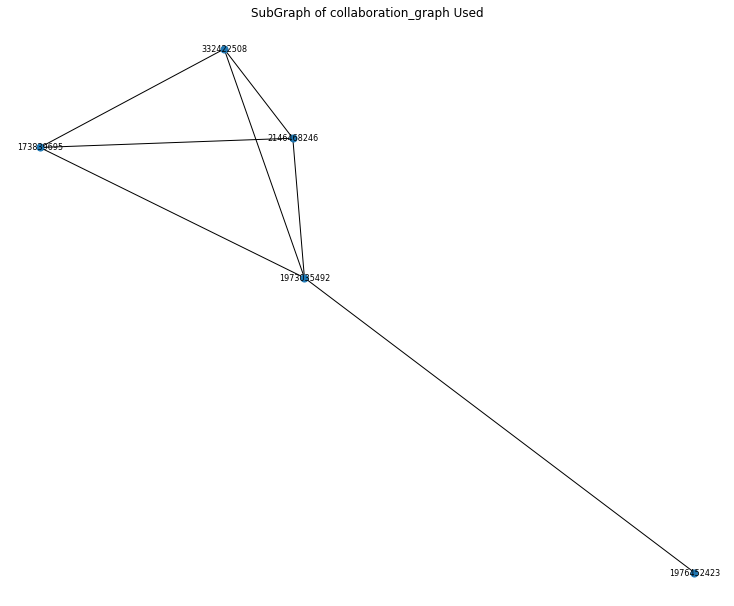

In [ ]:
authors_list = []
initial_node = 0
end_node = 0
N = 5

result = shortest_ordered_walk(collaboration_graph, initial_node, end_node, N)
graph_used=result[0]
path = result[1]
papers = result[2]

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graph_used)
nx.draw(graph_used, pos, with_labels=True, node_size=50, font_size=8)
plt.title('SubGraph of collaboration_graph Used')
plt.show()

**1. Print the papers needed to be crossed in the shortest walk in order**

In [ ]:
def get_papers_for_shortest_walk(G, path):
    # Initialize an empty list to hold the papers (edges) in the walk
    papers_in_walk = []

    # Iterate through the path and find the papers connecting each consecutive pair of authors
    for i in range(len(path) - 1):
        start_author = path[i]
        end_author = path[i + 1]

        # Retrieve the papers (or collaborations) associated with the edge
        # This assumes you have an attribute for each edge that lists the associated paper(s)
        # Adjust the attribute name as per your graph's data
        papers = G[start_author][end_author].get('titles', 'Unknown Paper')

        # If multiple papers are found, you might want to handle them here
        # For simplicity, we're assuming it's a single identifier
        papers_in_walk.append((start_author, end_author, papers))

    return papers_in_walk

In [ ]:
papers_in_walk = get_papers_for_shortest_walk(graph_used, path)
# Print the papers in order
print("Papers needed to be crossed in the shortest walk: \n")
for i, (start, end, paper) in enumerate(papers_in_walk, 1):
    print(f"{i}. Between {start} and {end}: Papers: {paper} +\n")

Papers needed to be crossed in the shortest walk: 

1. Between 1973035492 and 173839695: Papers: InterPro in 2017—beyond protein family and domain annotations +

2. Between 173839695 and 332422508: Papers: The Universal Protein Resource (UniProt) in 2010 +

3. Between 332422508 and 1973035492: Papers: InterPro: the integrative protein signature database +

4. Between 1973035492 and 1976452423: Papers: A promoter-level mammalian expression atlas +



**2. Plot the graph and identify the nodes and edges that appear in the shortest walk (please put an identifier on each edge in the shortest walk to determine the order that we should have the walk)**

In [ ]:
print(path)

[1973035492, 173839695, 332422508, 1973035492, 1976452423]


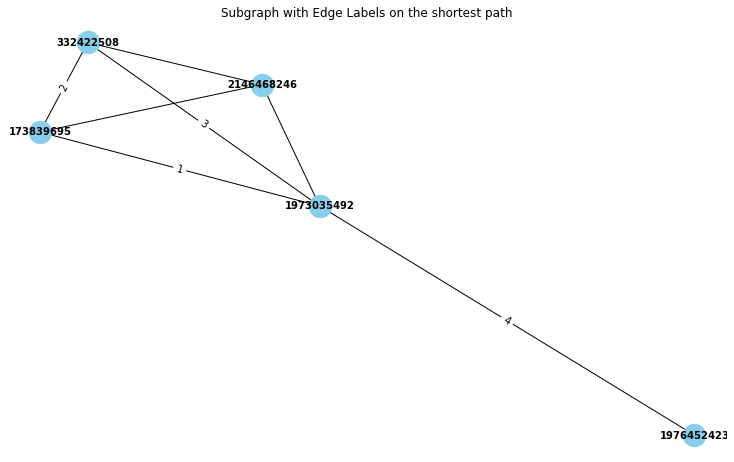

In [ ]:
# Create a dictionary of edge labels based on order in the shortest path
edge_labels = {(path[i], path[i + 1]): str(i + 1) for i in range(len(path) - 1)}

# Draw the subgraph with labels on the edges
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(graph_used)
nx.draw(graph_used, pos=pos, with_labels=True, node_color='skyblue', node_size=500, font_weight='bold', font_size=10)
nx.draw_networkx_edge_labels(shortest_path_subgraph, pos=pos, edge_labels=edge_labels)
plt.title('Subgraph with Edge Labels on the shortest path')
plt.show()

#### Visualization 4 - Visualize the disconnected graph

**1. Print the number of the links that should be disconnected**

**2.Plot the original graph**

**3. Plot the graph after removing the links and identify the two nodes**

#### Visualization 5 - Visualize the communities

In [ ]:
# Execute the function
min_edges, communities, same_community = functionality5(citation_graph, 50, 2161969291,1971784203)

# An overview of the Output using N=50
print("Minimum number of edges to be removed:", min_edges)
print("Communities:", communities)
print(f"Paper_1 and Paper_2 belong to the same community: {same_community}")

Minimum number of edges to be removed: 0
Communities: [{1686810756}, {2124651399}, {2161969291, 1971784203, 2163605009, 2162915993, 2159080219, 1995903777, 2119821739, 1988790447, 2121947440, 1501500081, 2153635508, 2296616510, 2151103935, 2124386111, 2031489346, 2117539524, 2076063813, 2066636486, 2147152072, 2164598857, 2102605133, 2618530766, 47957325, 2168356304, 2064675550, 2163922914, 2108598243, 2150341604, 1880262756, 2072128103, 2115167851, 2131846894, 2165949425, 2147800946, 2912934387, 1986931325}, {2100408980}, {1987198869}, {2118428193}, {2141885858}, {1791587663}, {1996360405}, {2096525273}, {2130509920}, {2156186849}, {2157457404}, {1660562555}, {2148251644}]
Paper_1 and Paper_2 belong to the same community: True


**1. Print the number of links that should be removed to have the communities**

In [ ]:
# Print the number of links to be removed
print(f"Number of links to be removed: {min_edges}")

Number of links to be removed: 0


**2. A table depicting the communities and the papers that belong to each community**

In [ ]:
# Print the number of communities
print("Number of Communities:", len(communities))

Number of Communities: 15


In [ ]:
def generate_markdown_table(communities):
    # Start the Markdown table
    markdown_table = "| Community # | Papers in Community                    |\n|-------------|---------------------------------------|\n"

    # Populate the table with community information
    for i, community in enumerate(communities, 1):
        papers_str = f"[{', '.join(map(str, community))}]"
        markdown_table += f"| {i}           | {papers_str.ljust(38)} |\n"

    return markdown_table

# Generate Markdown table
markdown_table = generate_markdown_table(communities)

# Print the table
print(markdown_table)

| Community # | Papers in Community                    |
|-------------|---------------------------------------|
| 1           | [1686810756]                           |
| 2           | [2124651399]                           |
| 3           | [2161969291, 1971784203, 2163605009, 2162915993, 2159080219, 1995903777, 2119821739, 1988790447, 2121947440, 1501500081, 2153635508, 2296616510, 2151103935, 2124386111, 2031489346, 2117539524, 2076063813, 2066636486, 2147152072, 2164598857, 2102605133, 2618530766, 47957325, 2168356304, 2064675550, 2163922914, 2108598243, 2150341604, 1880262756, 2072128103, 2115167851, 2131846894, 2165949425, 2147800946, 2912934387, 1986931325] |
| 4           | [2100408980]                           |
| 5           | [1987198869]                           |
| 6           | [2118428193]                           |
| 7           | [2141885858]                           |
| 8           | [1791587663]                           |
| 9           | [1996360405]           

**3.Plot the original graph**

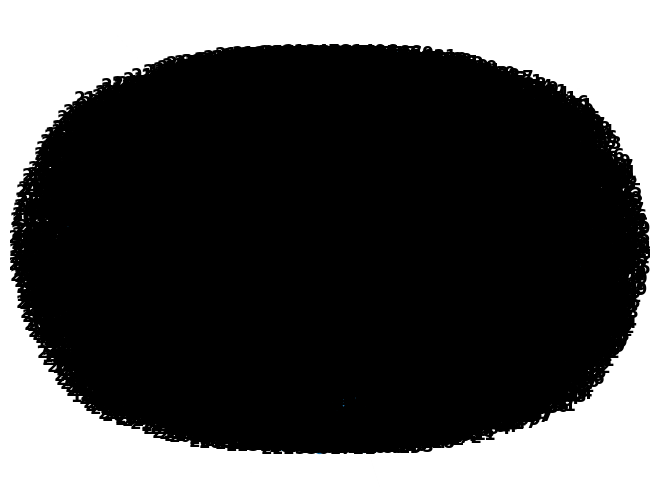

In [ ]:
# Create a spring layout for the graph
layout = nx.spring_layout(citation_graph)

# Draw the graph
nx.draw(citation_graph, pos=layout, with_labels=True, font_weight='bold', node_size=50)

# Show the plot
plt.show()

**4.Plot the graph showing the communities in the network**

<ipython-input-314-25f9cc675d61>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw(subgraph_communities, pos=layout, with_labels=True, font_weight='light', node_size=50, node_color=node_colors, cmap=plt.cm.get_cmap('viridis'), width=1, arrowsize=10, arrows = False)


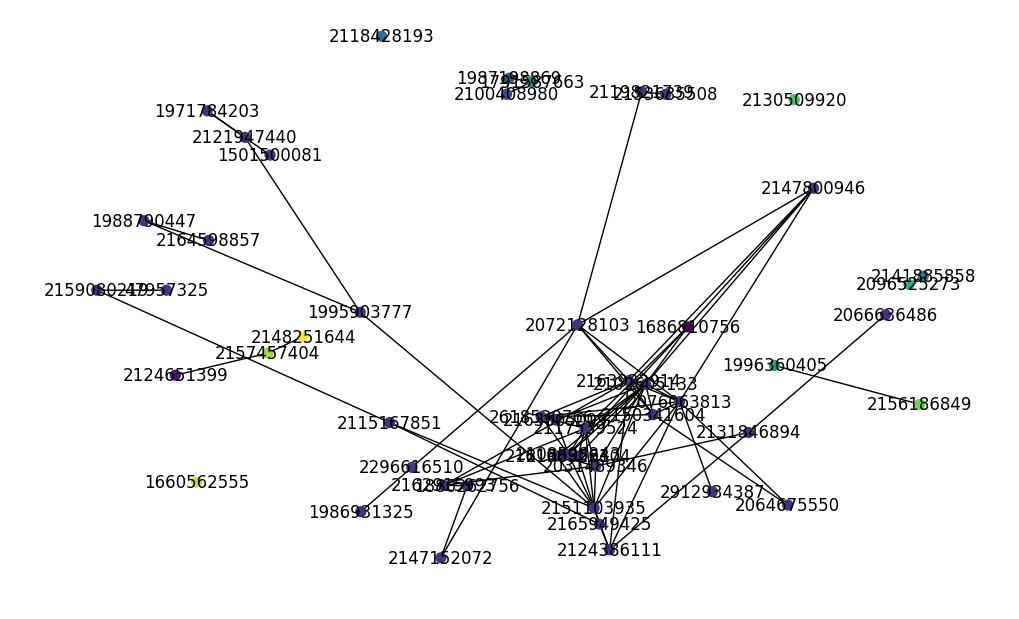

In [ ]:
# Assume that the communities and citation_graph are already defined
# communities is a list of sets, where each set contains the nodes belonging to a particular community
# citation_graph is your original graph

# Create a list of all nodes in the communities
top_papers = list(set(node for community_nodes in communities for node in community_nodes))

# Extract the subgraph containing only the nodes of the communities
subgraph_communities = citation_graph.subgraph(top_papers).copy()

# Set the layout for the plot
layout = nx.spring_layout(subgraph_communities)

# Create a list of colors for the nodes based on the community
node_colors = []
for node in subgraph_communities.nodes():
   for i, community_nodes in enumerate(communities):
       if node in community_nodes:
           node_colors.append(i)

# Draw the graph
plt.figure(figsize=(10, 6))
nx.draw(subgraph_communities, pos=layout, with_labels=True, font_weight='light', node_size=50, node_color=node_colors, cmap=plt.cm.get_cmap('viridis'), width=1, arrowsize=10, arrows = False)

# Show the plot
plt.show()

**5.Plot the final graph and identify the community/communities of Paper_1 and Paper_2**

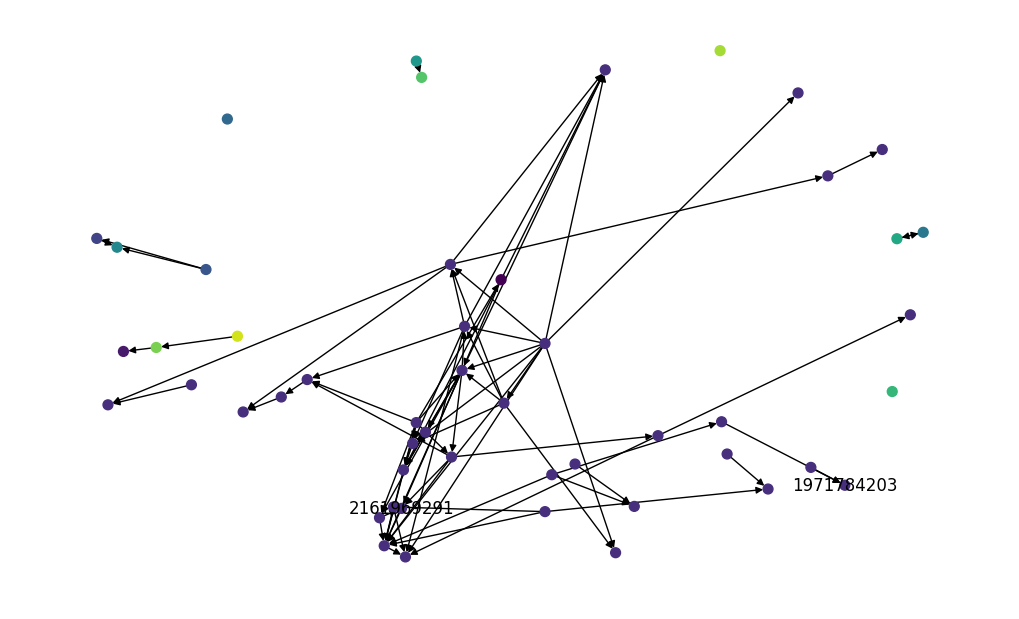

In [ ]:
Paper_1 = 2161969291
Paper_2 = 1971784203

# Assume that the communities and citation_graph are already defined
# communities is a list of sets, where each set contains the nodes belonging to a particular community
# citation_graph is your original graph
# Paper_1 and Paper_2 are the nodes that you want to highlight

# Create a list of all nodes in the communities
top_papers = list(set(node for community_nodes in communities for node in community_nodes))

# Extract the subgraph containing only the nodes of the communities
subgraph_communities = citation_graph.subgraph(top_papers).copy()

# Set the layout for the plot
layout = nx.spring_layout(subgraph_communities)

# Create a list of colors for the nodes based on the community
node_colors = []
for node in subgraph_communities.nodes():
 community_of_node = next((community for community in communities if node in community), None)
 if community_of_node is not None:
     community_index = communities.index(community_of_node)
     color = matplotlib.colormaps['viridis'](community_index / len(communities))
 else:
     color = 'gray' # Default color for other nodes
 node_colors.append(color)

# Draw the graph without edges
plt.figure(figsize=(10, 6))

# Draw the nodes of the communities
nx.draw(subgraph_communities, pos=layout, with_labels=False, node_size=50, node_color=node_colors, cmap=matplotlib.colormaps['viridis'], width=1, arrowsize=10)

# Set edge_color='none' to avoid drawing edges between nodes
#nx.draw(subgraph_communities, pos=layout, edge_color='none')

# Show labels for Paper_1 and Paper_2
show_labels = [Paper_1, Paper_2]
labels = {node: node for node in show_labels}
nx.draw_networkx_labels(subgraph_communities, pos=layout, labels=labels)

# Show the plot
plt.show()

We can see from the graph that the two paper we selected as an input for the representation (2161969291, 1971784203) are indeed from the same community, as we can see from the table depicting the communities and the papers that belong to each community.

## **[4] Command Line Question (CLQ)**

**Important note:** You may work on this question in any environment (AWS, your PC command line, Jupyter notebook, etc.), but the final script must be placed in CommandLine.sh, which must be executable. Please run the script and include a screenshot of the output in the notebook for evaluation.

We answer the Questions
1.  Is there any node that acts as an important "connector" between the different parts of the graph?
2.  How does the degree of citation vary among the graph nodes?
3.  What is the average length of the shortest path among nodes?
with one bash-file. First we explain we approached the questions, then the output is shown.

**Ad 1.**
To answer this question one could search for nodes to break up connected subgraphs. Here one should avoid breaking up just leaves or very small parts of the graph. The philosophy should be:
-   the more nodes each new subgraph has the better
- the more subgraphs emerge the better
And one would have to balance these goals.

However this is a very costly approach in terms of computation time.

Another approach is using centrality measures (Degree Centrality, Closeness Centrality, Betweenness-Centrality, Harmonic Centrality, ...). These are approaches to measure the centrality or importance of a node by some of its properties. For example the degree-centrality uses only the degree of each node to determine its centrality.

However given the above stated time-consuming problem we decided that the betweenness-centrality $c_B$ would serve our purpose best. The definition is given here:

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html

After computing this measure for our graph, we wanted to determine if - based on this measure - there are important connectors or if there are not. We decided to detect an upper outlier by the same approach as in a boxplot. Hence whenever

$$c_B(v) > 1.5 \cdot \textrm{iqr} + q_3$$

for a node $v$ holds true, $v$ is supposed to be an upper outlier, hence important.
Here $c_B(v)$ denotes the betweenness-centrality of node $v$, $\textrm{iqr}$ denotes the interquantilerange and $q_3$ determines the third quartile, hence the 75%-quantile.


**Ad 2.**
To answer the question of "Variation" appropriately we decided to compute some standard-statistics to get a grasp of how the degree varies.


**Ad 3.**
To compute the average length of the shortest path among the nodes we concentrated on strongly connected subcomponents with at least 2 nodes.
To consider strongly connected subgraphs is necessery, since the graph itself is directed and disconnected. For each node in the graph there exists at least one node in the graph, which is not reachable. Hence the searched measure would be infinite.
Further shortest paths from a node to a node itself don't seem to make much sense. Hence we excluded also those.

 <img src="clq.PNG" alt="here should be shown the clq output">

## **[5] Algorithmic Questions (AQ)**
### **Part A**

#### *5.1) The Algorithm*

What we are basically asked to do is to select M athletes such that the sum of their scores in the M corresponding skills is maximized. \\
We need to keep track of the top M athletes based on their potential scores, updating this list whenever we encounter an athlete whose potential score is higher than the lowest score currently in the list.

- With 1st. input

In [ ]:
#S = 1
# Read the number of athletes and skills
n, m, s = map(int, input().split()) #constant

# Read the optimal set of skills
optimal_skills = input().split() #constant

# Initialize a dictionary to store each athlete's skills and scores
athletes = {} #constant
   # Step 1: read the input
athletes_dict = {} #constant
for i in range(n):
  id = int(input())
  skills = {}
  for _ in range(s):
    skill, score = input().split()
    skills[skill] = int(score)
  athletes_dict[id] = skills

14 10 1
SWM VOL ATH VOL VOL BSK HCK BSK SWM BSK
1
BSK 98
2
ATH 14
3
HCK 82
4
HCK 9
5
FTB 90
6
ATH 52
7
HCK 95
8
TEN 85
9
RGB 46
10
SWM 16
11
VOL 32
12
SOC 41
13
SWM 59
14
SWM 34


In [ ]:
#1: Sort the athletes by their scores in the optimal skills
athletes_sorted = {}
for skill in optimal_skills:
 athletes_sorted[skill] = sorted([(athletes_dict[val][skill], val) for val in athletes_dict.keys() if skill in athletes_dict[val]], key=lambda x: x[0], reverse=True)

#2: Select the top athlete for each skill
selected_athletes = {}
for skill in optimal_skills:
 for _, athlete_id in athletes_sorted[skill]:
  if athlete_id not in selected_athletes:
    selected_athletes[athlete_id] = skill
    break

#3: Compute the team's overall score
team_score = sum([athletes_dict[athlete_id][skill] for athlete_id, skill in selected_athletes.items()])

print(team_score)

370


- With 2nd input

In [ ]:
#S = 2
# Read the number of athletes and skills
n, m, s = map(int, input().split()) #constant

# Read the optimal set of skills
optimal_skills = input().split() #constant

# Initialize a dictionary to store each athlete's skills and scores
athletes = {} #constant
   # Step 1: Parse the input
athletes_dict = {} #constant
for i in range(n):
  id = int(input())
  skills = {}
  for _ in range(s):
    skill, score = input().split()
    skills[skill] = int(score)
  athletes_dict[id] = skills

14 10 2
SWM VOL ATH VOL VOL BSK HCK BSK SWM BSK
1
BSK 98 
HCK 12
2
ATH 14 
VOL 1
3
HCK 82 
ATH 30
4
HCK 9 
SWM 27
5
FTB 90
HCK 50
6
ATH 52 
RGB 80
7
HCK 95 
SWM 11
8
TEN 85 
RGB 7
9
RGB 46 
SWM 30
10
SWM 16 
BSK 12
11
VOL 32 
HCK 40
12
SOC 41 
FTB 12
13
SWM 59 
TEN 82
14
SWM 34 
VOL 20


In [ ]:
# Sort the athletes by their scores in the optimal skills
athletes_sorted = {}
for skill in optimal_skills:
 athletes_sorted[skill] = sorted([(athletes_dict[val][skill], val) for val in athletes_dict.keys() if skill in athletes_dict[val]], key=lambda x: x[0], reverse=True)

# Select the top athlete for each skill
selected_athletes = {}
for skill in optimal_skills:
 for _, athlete_id in athletes_sorted[skill]:
  if athlete_id not in selected_athletes:
    selected_athletes[athlete_id] = skill
    break

# Compute the team's overall score
team_score = sum([athletes_dict[athlete_id][skill] for athlete_id, skill in selected_athletes.items()])

print(team_score)

399


#### *5.2) Time complexity*

The algorithm code can be divided into four parts:

1. **Reading the inputs and initializing a dictionary to store each athlete's skills and scores** \\
The outermost loop in the code reads the number of athletes. The inner loop reads the number of skills. So, the outer loop runs 'n' times and the inner loop runs 's' times for each iteration of the outer loop. \\
This results in a time complexity of O(n * s), where 'n' is the number of athletes and 's' is the number of skills.

2. **Sort the athletes by their scores in the optimal skills:** \\
This part of the code involves sorting the athletes based on their scores in the optimal skills.
The time complexity of this part is O(n * m * s) because there are 'n' athletes, 'm' skills, and for each athlete, we iterate through their skills for a total of 'n * m * s' iterations.

3. **Select the top athlete for each skill:** \\
This part of the code involves selecting the top athlete for each skill in the optimal set.
The time complexity of this part is O(n * m) because for each skill in the optimal set, we iterate through the athletes for a total of 'n * m' iterations.

4. **Compute the team's overall score:** \\
This part of the code involves calculating the overall score of the team.
The time complexity of this part is O(n * m) because we iterate through each athlete in the selected athlete list for a total of 'n * m' iterations.

However, since these parts of the code are nested within each other, their time complexities are multiplied together to get the final overall time complexity of O(n * m * s).

Therefore, the Overall time complexity of the code is O(n * m * s).


#### *5.3) Time complexity - ask the AI*

BY asking Phind we get the following answer: \\
The time complexity of your code can be analyzed as follows:

1. **Reading the input:** This part of the code runs in O(n) time complexity, where n is the number of athletes. Each athlete's skills are read once, and the time complexity of reading a single athlete's skills is O(s), where s is the number of skills. Therefore, the total time complexity is O(n*s).
2. **Sorting athletes by their scores in the optimal skills:** This part of the code runs in O(mnlog(n)) time complexity. For each skill in optimal_skills, we iterate over all athletes and sort them by their scores in that skill. The sorting operation has a time complexity of O(nlog(n)). Since there are m skills, the total time complexity becomes O(mn*log(n)).
3. **Selecting the top athlete for each skill:** \\
 This part of the code runs in O(m*n) time complexity. We iterate over each skill in optimal_skills and for each skill, we iterate over all athletes. In the worst case, we have to iterate over all athletes for each skill.
4. **Computing the team's overall score:** This part of the code runs in O(n) time complexity. We iterate over each athlete in selected_athletes once. \\
Adding up these complexities, the overall time complexity of the code is O(mns).

So we can say that both our answer and the AI tool answer are the same.

#### *5.4) Polynomial time alternative*

Our algorithm has O(m*n*s) time complexity, which is already polynomial

#### *5.5) What if S = 1?*

If the number of skills (S) is 1, the time complexity of the algorithm simplifies significantly, because all the O(n) become O(1). \\

1. **Reading the inputs and initializing a dictionary to store each athlete's skills and scores** \\
(n*s) becomes O(s)

2. **Sort the athletes by their scores in the optimal skills:** \\
O(n*m*s) becomes O(n*m)

3. **Selecting the top athlete for each skill:** \\
O(m*n) stays the same

4. **Compute the team's overall score:** \\
O(n) stays the same too

### **Part B**

#### *5.1) Prove or disprove that the problem is NP-complete*

- A problem P is ***NP-Complete*** if:
1. P &isin; NP
2. Every problem in NP can be reduced in polytime to P.

*Remark that, P &isin; NP if I can check in a polytime whether a given solution is correct.*

- The solution for this problem can be checked in a polytime. This allows us to say that it is in NP.
- We can proof that P is NP complete by considering that the **SAT** (Boolean Satisfiability Problem) is NP complete. In this case, solving SAT allows us to obtain a possible solution for our problem.
    - **Proof:**
        - Let be x( Si, Ij) = 1 if the individual j (n total individuals) has the skill i (k total skills). In this scenario, the SAT problem can be the following:
        
            *{ **[x(S1,I1) OR x(S1,I2) OR ... OR x(S1,In)]** AND **[x(S2,I1) OR x(S2,I2) OR ... OR x(S2,In)]** AND ... AND **[x(Sk,I1) OR x(Sk,I2) OR ... OR x(Sk,In)]** }.*

            We can rapresent this situation with a matrix in which each row rapresent a skill and each column rapresent an individual. The goal is to obtain at least a 1 for each row. If we consider the number of ones for each row as a score, the total score related to all the rows should be at least k (the total number of skills). If the total score is at least k, we could say that all the skills are covered and a possible solution exists. If a possible solution S for our problem P exists, then it is possible to create an algorithm to solve SAT, which uses S, to solve SAT. P is at least as difficult as SAT.
            
            **- In conclusion, SAT can be reduced to P and SAT is NP-complete implies that P is NP-complete.**

#### *5.2) Write a heuristic in order to approximate the best solution for this problem*

In order to get an heuristic we are going into some steps:

1. We obtain a subgraph in which nodes (and edges related to those nodes) with no requested skills are deleted.
2. We initialize an empty set of individuals V'.
3. We initialize the list of requested skills T.
4. From the subgraph, we randomly select a node *j* and add it to V'. This node *j* would be our root. The skill related to *j* is removed from T.  
5. Starting from a root we are going to initialize an algorithm.

    - 5.1. Among all the nodes connected to the root, we take the one with the minimum cost having at least one of the skills present in T. Update T removing the skill. We add the selected node v to V'.
    
    - 5.2. From the previous selected node, we repeate the 5.1 until all the skills are covered.

#### *5.3) What is the time complexity of your solution ?*

1. **Delete nodes and edges without requested skills:**
    - Complexity: O(V * S), where V is the number of nodes and S is the avarage number of skills per node.

2. **Initialize empty set of individuals V':**
    - Complexity: O(1).

3. **Initialize list of requested skills T:**
    - Complexity: O(T), where T is the number of requested skills.

4. **Randomly select a node *j* from the subgraph:**
    - Complexity: O(1).

5. **Algorithm starting from the root:**
    - 5.1. Among connected nodes, select minimum cost node with at least one skill in T.
        - Complexity: O(T^2 * S) in the worst case, where T is the number of requested skills.
    - 5.2. Repeat 5.1 until all skills are covered.
        - Complexity: O(V' * T^2 * S) in the worst case, we repeat 5.1 for V' times, as V' is the number of nodes in the subgraph.
        
**POLYTIME.**